# Image Application: cat or not?

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 
- Learn how to do data normalization
- learn how to do weight initialization
- Learn how to use regularization

Let's get started!

## 1 - Packages

**Exercise**: Please mount your Google drive, and set up your working folder here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
# start your code here
os.chdir("/content/drive/MyDrive//Homework4/regularization_tf") # change your working folder here
# end your code here

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the customized functions that will be used in this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [3]:
import time
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import dnn_app_utils_v3 as du
from skimage.transform import rescale, resize, downscale_local_mean

# refresh 'planar_utils' module
import imp
imp.reload(du)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)
tf.random.set_seed(1)

## 2 - Dataset

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

The training input and output are stored in 'train_x_orig' and 'train_y'. The test input and output are stored in 'test_x_orig' and 'test_y'. 

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = du.load_data()
#print(classes)

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


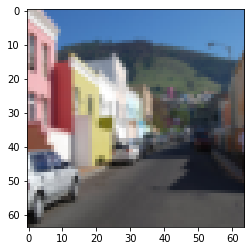

In [5]:
# Example of a picture
index = 1
train_y=train_y.reshape(209,1)
test_y=test_y.reshape(50,1)
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[index,0]) + ". It's a " + classes[train_y[index,0]].decode("utf-8") +  " picture.")
#print(train_x_orig[index].shape,train_x_orig[index])

Let's explore more about the training data. We are curious about the shape of each image and can use 'train_x_orig[index].shape' to expore it. 
**Exercise**: Can you tell what the pixel number of each image is?

In [6]:
# Explore your dataset 
image_shape=train_x_orig[index].shape
print("Each image is of size: ", image_shape)
#start your code here
num_px=None   # the number of pixels in each column of the image. Hint: The 1st element in image_shape indicates this number?
#end your code here
print('Number of pixels in each column of the image:', num_px)

Each image is of size:  (64, 64, 3)
Number of pixels in each column of the image: None


We just take a close look at an image of the image set. Now, let's take a look at the whole training set. 

**Exercise**: The first 4 lines in the following cell print out the shape of the trining images. There are 209 images, and each image has 64 by 64 pixcels and GRB color. 

Please print out the shape of the test input (stored in `test_x_orig`) and output (stored in `test_y`) data, and tell how many images we have in the test data. 

In [7]:
train_x_shape=train_x_orig.shape
m_train = train_x_shape[0]
print ("train_x_orig shape: ",train_x_shape)
print ("Number of training examples: " ,m_train)
# start your code here
test_x_shape=None
test_y_shape=None
m_test = None
# end your code here

print ("test_x_orig shape: " ,test_x_shape)
print ("test_y shape: " , test_y_shape)
print ("Number of test examples: " ,m_test)

train_x_orig shape:  (209, 64, 64, 3)
Number of training examples:  209
test_x_orig shape:  None
test_y shape:  None
Number of test examples:  None


As mentioned in our lecture, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

![alt text](https://drive.google.com/uc?id=12XXwVJpcT-moegSdzejC-W-hD79qDSk9)
<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

Data normalization can help us accelerate the training process. The RGB values of an image are integers in the range of [0,255]. We can normalize the training images to have the feature values between 0 and 1 by using `train_x = train_x_flatten/255.0`.

**Exercise**: We normalize the training images using `train_x = train_x_flatten/255.0` in the 1st line. Please normalize the test images to have feature values between 0 and 1.

In [9]:
# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.0

#start your code here
test_x = test_x_flatten/255.0
#end your code here

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (209, 12288)
test_x's shape: (50, 12288)
train_y's shape: (209, 1)
test_y's shape: (50, 1)


###3- Build your neural network ###
Now, we are going to use the skills in the first module to build our neural network. 

Excep the input layer, you can use 

`tf.keras.layers.Dense(20,activation='relu', 
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros')`

to build the layers. In this example, we have 20 neurons in this layer, use 'relu' as the activation function, initialize our weight randomly using 'glorot_uniform', and our bias is initialized to be 'zeros'. 

First, we will need an input layer. How many neurons will you need in the input layer? Hint: how many elements does every training input have?

Second, we will build several hidden layers. You are free to choose the number of neurons in every hidden layer. 

Last, we will build the output layer. How many neurons will you need in the output layer? Which activation function is more suitale in this problem? Hint: how many elements does every training output have? What is the range of the training output?


In [10]:
tf.random.set_seed(1) # we fixed the seed of the random number generator, so every time running this code, we can have the same results.

# start your code here
cat_model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(12288)), # how many elements are there in every training image?
    tf.keras.layers.Dense(20,activation='relu', # in layer 1, we will have 20 neurons and use 'relu' as the activation function
                            kernel_initializer='glorot_uniform', # we will randomly choose the initial weight using the 'glorot_uniform' method
                            bias_initializer='zeros'), # we will initialize all bias to be zeros.
    #please follow the example of layer 1 to add more hidden layers here. 
    tf.keras.layers.Dense(20,activation='relu', # in layer 2, we will have 20 neurons and use 'relu' as the activation function
                            kernel_initializer='glorot_uniform', # we will randomly choose the initial weight using the 'glorot_uniform' method
                            bias_initializer='zeros'), # we will initialize all bias to be zeros.
    # End adding hidden layers                    
    tf.keras.layers.Dense(1,activation='sigmoid', # how many elements are there in every training output
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros'),
])
# end your code here
cat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                245780    
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 246,221
Trainable params: 246,221
Non-trainable params: 0
_________________________________________________________________


Now, let's compile the model. When comiling your model, you will need to specify the optimizer, the loss function, and the metrics.

For optimizers, the most popular ones are 'Adam' and its derivatives. You can also try 'RMSprop' and 'SGD' to see which one works better for you. You might need adjust the learning rate to acceperate the training process. 

For loss functions, our problem is a two-class classification problem. The most popular loss function would be 'BinaryCrossentropy'. If this is a multiple-class classification problem, you probably want to try 'CategoricalCrossentropy' or 'SparseCategoricalCrossentropy'. 

For the metrics, we want to know the accuracy of our model. Therefore, I would recommend 'accuracy'. 

In [11]:
# start your code here
cat_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Optimizer. Please change 'None' to some meaningful learning rate which is usually <1
    # Loss function to minimize
    loss=tf.keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
                 )
# end your code here

It's time to train. 

We can plot training history. It can help us to adjust the parameters. 

If the training loss increases, we may want to decrease the `learning_rate`.

If the training loss has large vibration, we may want to decrease the `learning_rate`. 

If the training loss decreases too slowly, we need to increase `learning_rate`.

If the training loss decreases at a good speed, but ends up large, we may want to increase the epoch number. 

Epoch 1/75
5/5 [==============================] - 2s 158ms/step - loss: 4.6542 - accuracy: 0.5753 - val_loss: 7.0954 - val_accuracy: 0.3175
Epoch 2/75
5/5 [==============================] - 0s 32ms/step - loss: 4.8382 - accuracy: 0.4795 - val_loss: 5.0314 - val_accuracy: 0.6825
Epoch 3/75
5/5 [==============================] - 0s 23ms/step - loss: 3.2119 - accuracy: 0.5068 - val_loss: 3.4303 - val_accuracy: 0.3810
Epoch 4/75
5/5 [==============================] - 0s 23ms/step - loss: 1.8286 - accuracy: 0.5616 - val_loss: 3.3140 - val_accuracy: 0.6667
Epoch 5/75
5/5 [==============================] - 0s 20ms/step - loss: 1.7540 - accuracy: 0.6849 - val_loss: 1.7707 - val_accuracy: 0.3968
Epoch 6/75
5/5 [==============================] - 0s 26ms/step - loss: 1.7335 - accuracy: 0.4658 - val_loss: 1.1306 - val_accuracy: 0.6667
Epoch 7/75
5/5 [==============================] - 0s 33ms/step - loss: 1.2662 - accuracy: 0.6575 - val_loss: 1.1010 - val_accuracy: 0.6667
Epoch 8/75
5/5 [==========

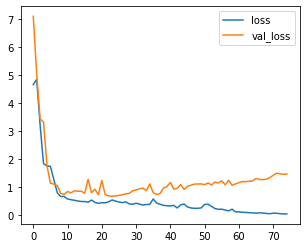

In [12]:
# start your code here
history = cat_model.fit(
    train_x, # input data
    train_y, # real output data
    validation_split=0.3, # this number is usually betwwen 0 and 0.3. It is the portion used as validation data, 
    epochs=75, # how many iterations do you want to train your model? Your data will be reused to train the model for the number of epochs. I trained 5 min for this model
)
# end your code here. 
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

### 4. test ###
Let us test their performance using our test dataset. The test dataset is never used to train the models, and reflects the acutual performance of the model when it is used in the general images.

To evaluate the model , we can use
`cat_model.evaluate(test_x,test_y)`. 

In [13]:
cat_model.evaluate(test_x,test_y)

2/2 [==============================] - 0s 10ms/step - loss: 1.0457 - accuracy: 0.7200


[1.0456546545028687, 0.7200000286102295]

The expected accuracy is higher than 0.7. If the accuracy is lower than 0.7, you may want to increase the epoch number, adjust the learning rate, and the regularizer weight, to achieve the goal. 

For your reference, I trained the model for 5 min to achieve that goal. 

If you have achieved the 0.7 goal, I would like to challenge you for the 0.8 accuracy for the test set. 

### 5- Adding Regularization ###
After enough training, you probably notice that while the training loss is very small, the validation loss is quite large. This is what we called **low bias high vairance** problem. We have several ways to deal with it, 
1. L1/L2 regularization, 
2. drop out, and 
3. early stop. 

I would recommend you try the regularization first, because it's easy to use and usually works. 

To add regularization to the network, we only need to specify this option in the 'Dense' layer as follows.

`tf.keras.layers.Dense(20,activation='relu', 
                          kernel_initializer='glorot_uniform',
                          bias_initializer='zeros', 
                          kernel_regularizer=tf.keras.regularizers.L2(0.01))`

The parameter **kernel_regularizer=tf.keras.regularizers.L2(0.01)** says that we want an 'L2' regularizer with weight 0.01. A higher weight usually can reduce the validation loss more. But if the weight is too large, the training loss might redecus very slowly.

In [14]:
tf.random.set_seed(1)
cat_model_regu=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(12288)),
    tf.keras.layers.Dense(20,activation='relu', # in layer 1, we will have 20 neurons and use 'relu'
                          kernel_initializer='glorot_uniform',# we will randomly choose the initial weight using the 'glorot_uniform' method as the activation function
                          bias_initializer='zeros', # we will initialize all bias to be zeros.
                          kernel_regularizer=tf.keras.regularizers.L2(0.01)), # L2-regularization can be added here
    #please feel free to add more hidden layers with regularizer
    tf.keras.layers.Dense(10,activation='relu', # in layer 2, we will have 10 neurons and use 'relu'
                          kernel_initializer='glorot_uniform',# we will randomly choose the initial weight using the 'glorot_uniform' method as the activation function
                          bias_initializer='zeros', # we will initialize all bias to be zeros.
                          kernel_regularizer=tf.keras.regularizers.L2(0.01)), # L2-regularization can be added here
    # End adding hidden layers 
    tf.keras.layers.Dense(1,activation='sigmoid', 
                            kernel_initializer='glorot_uniform',
                            bias_initializer='zeros', 
                            kernel_regularizer=tf.keras.regularizers.L2(0.01)),
])

cat_model_regu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                245780    
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 246,001
Trainable params: 246,001
Non-trainable params: 0
_________________________________________________________________


Now, you can compile and train the regularized neural network as before.

In [15]:
# start your code here
cat_model_regu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Optimizer please change "None" to some meaningful number here
    # Loss function to minimize
    loss=tf.keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
                 )
# end your code here. 

Epoch 1/190
6/6 [==============================] - 1s 43ms/step - loss: 1.2273 - accuracy: 0.5928 - val_loss: 1.1633 - val_accuracy: 0.7143
Epoch 2/190
6/6 [==============================] - 0s 12ms/step - loss: 1.1805 - accuracy: 0.6407 - val_loss: 1.1527 - val_accuracy: 0.7143
Epoch 3/190
6/6 [==============================] - 0s 11ms/step - loss: 1.1791 - accuracy: 0.6407 - val_loss: 1.1603 - val_accuracy: 0.7143
Epoch 4/190
6/6 [==============================] - 0s 12ms/step - loss: 1.1647 - accuracy: 0.6766 - val_loss: 1.1662 - val_accuracy: 0.6905
Epoch 5/190
6/6 [==============================] - 0s 11ms/step - loss: 1.1436 - accuracy: 0.6707 - val_loss: 1.1444 - val_accuracy: 0.7143
Epoch 6/190
6/6 [==============================] - 0s 14ms/step - loss: 1.1370 - accuracy: 0.6647 - val_loss: 1.1505 - val_accuracy: 0.7143
Epoch 7/190
6/6 [==============================] - 0s 11ms/step - loss: 1.1155 - accuracy: 0.6707 - val_loss: 1.1467 - val_accuracy: 0.7143
Epoch 8/190
6/6 [===

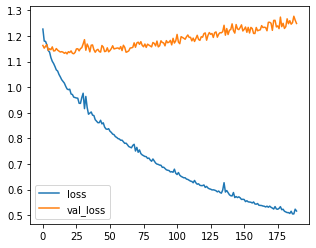

In [16]:
# start your code here
history_regu = cat_model_regu.fit(
    train_x, # input data
    train_y, # real output data
    validation_split=0.2, # this number is usually betwwen 0 and 0.3. It is the portion used as validation data, 
    epochs=190, # how many iterations do you want to train your model? Your data will be reused to train the model for the number of epochs. I trained 5 min for this model
)
# end your code here

plt.figure()
plt.plot(history_regu.history['loss'])
plt.plot(history_regu.history['val_loss'])
plt.legend(['loss','val_loss'])

After the training, we can evaluate the regularized NN use the following command. 

In [17]:
cat_model_regu.evaluate(test_x,test_y)

2/2 [==============================] - 0s 9ms/step - loss: 0.9520 - accuracy: 0.8400


[0.9519703388214111, 0.8399999737739563]

The expected accuracy is highter than 0.8. 